## Importando Bibliotecas

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline

## Definindo Hiperparâmetros

In [2]:
args = {
    'batch_size': 100,
    'num_workers': 16,
    'epoch_num': 300,
    'lr': 0.006,
    'weight_decay': 3e-05,
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

args

{'batch_size': 100,
 'num_workers': 16,
 'epoch_num': 300,
 'lr': 0.006,
 'weight_decay': 3e-05,
 'device': device(type='cpu')}

## Lendo arquivo com os dados

In [3]:
df = pd.read_csv('dados/sp_completo.csv')
# df = pd.read_csv('dados/carros_sem_outliers.csv')
# df = pd.read_csv('dados/ka_sp.csv')
# df = pd.read_csv('dados/hb20_sp.csv')
# df = pd.read_csv('ford_sp.csv')
# df = pd.read_csv('ford_sp.csv')
# df = pd.read_csv('ford_sp.csv')
# df = pd.read_csv('ford_sp.csv')
df.head()

,modelo,marca,combustivel,cambio,direcao,cor,ano,quilometragem,potenciamotor,blindado,valor
0,1,12,5,0,2,9,2018,49906,2.0,0,150900.0
1,3,30,6,0,2,3,2017,25000,2.0,0,283000.0
2,5,65,5,0,2,0,2017,137000,3.0,0,139000.0
3,5,65,5,0,2,0,2016,108900,3.0,0,128900.0
4,5,65,5,0,2,7,2015,89000,3.0,0,124499.0


In [4]:
df.describe().round(2)

,modelo,marca,combustivel,cambio,direcao,cor,ano,quilometragem,potenciamotor,blindado,valor
count,24631.00,24631.00,24631.0,24631.00,24631.00,24631.00,24631.00,24631.00,24631.00,24631.00,24631.00
mean,2351.81,47.13,4.2,1.01,1.55,4.45,2017.06,62186.03,1.53,0.02,69659.29
std,1302.88,22.74,0.6,1.00,0.55,3.63,1.49,79219.92,0.43,0.14,44512.23
min,1.00,4.00,1.0,0.00,0.00,0.00,2015.00,1.00,1.00,0.00,1000.00
25%,1244.00,29.00,4.0,0.00,1.00,0.00,2016.00,39000.00,1.00,0.00,42990.00
50%,2321.00,57.00,4.0,2.00,2.00,5.00,2017.00,58000.00,1.60,0.00,55900.00
75%,3504.00,68.00,4.0,2.00,2.00,7.00,2018.00,80000.00,1.80,0.00,81999.50
max,4702.00,77.00,6.0,2.00,3.00,9.00,2019.00,11111111.00,4.00,1.00,780000.00


In [5]:
print(f'Quantidade de registros e de colunas: {df.shape}')

Quantidade de registros e de colunas: (24631, 11)


## Separando em conjunto de teste e de treino

In [6]:
indices = torch.randperm(len(df)).tolist()

train_size = int(0.8*len(df))

df_train = df.iloc[indices[:train_size]]
df_test = df.iloc[indices[train_size:]]

df_train.to_csv('car_train.csv', index=False)
df_test.to_csv('car_test.csv', index=False)

print(df_train.shape, df_test.shape)

(19704, 11) (4927, 11)


## Classe Carro

In [7]:
class Car(Dataset):
    def __init__(self, csv_path, columns):
        self.dados = pd.read_csv(csv_path).to_numpy()        
        self.columns = columns

    def __getitem__(self, idx):        
        sample = self.dados[idx][:self.columns]
        label = self.dados[idx][-1:]

        sample = torch.from_numpy(sample.astype(np.float32))
        label = torch.from_numpy(label.astype(np.float32))

        return sample, label

    def __len__(self):
        return len(self.dados)


## Carregando dados de treino e de teste

In [8]:
train_set = Car('car_train.csv', df.shape[1]-1)
test_set = Car('car_test.csv', df.shape[1]-1)

train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)

test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

## Criando MLP

In [9]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(MLP, self).__init__()

        self.features = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, out_size),
            nn.ReLU(),
        )

    def forward(self, X):

        hidden = self.features(X)
        output = self.classifier(hidden)

        return output

In [10]:
input_size = train_set[0][0].shape[0]
hidden_size = int((train_set[0][0].shape[0] + 1) / 2)
out_size = 1

net = MLP(input_size, hidden_size, out_size).to(args['device'])

net

MLP(
  (features): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=5, out_features=1, bias=True)
    (1): ReLU()
  )
)

## Definindo loss e otimizador

In [11]:
criterion = nn.L1Loss().to(args['device'])
diferenca = nn.L1Loss().to(args['device'])

#optimizer = optim.Adam(net.parameters(), 
#                       lr=args['lr'], 
#                       weight_decay=args['weight_decay'])

optimizer = optim.Adam(net.parameters())

dif_train, dif_test = [], []

## Treino e Validação

In [12]:
def train(train_loader, net, epoch):
    # Training mode
    net.train()
    start = time.time()
    epoch_loss  = []    
    epoch_dif = []
    
    for batch in train_loader:
        dado, rotulo = batch
    
        # Cast do dado na GPU
        dado = dado.to(args['device'])
        rotulo = rotulo.to(args['device'])

        optimizer.zero_grad()
        
        # Forward
        ypred = net(dado)
        loss = criterion(ypred, rotulo)
        
        dif = diferenca(ypred, rotulo)
        dif_train.append(dif.cpu().data)
        
        epoch_dif.append(dif.cpu().data)
        epoch_loss.append(loss.cpu().data)

        # Backpropagation
        loss.backward()
        optimizer.step()
   
    epoch_loss = np.asarray(epoch_loss)
    epoch_dif = np.asarray(epoch_dif)
  
    end = time.time()
    print('#################### Train ####################')
    print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_dif.mean(), end-start))

    return epoch_loss.mean()

In [13]:
def validate(test_loader, net, epoch):
    # Evaluation mode
    net.eval()
    start = time.time()
    epoch_loss  = []
    epoch_dif = []

    with torch.no_grad(): 
        for batch in test_loader:
            dado, rotulo = batch

            # Cast do dado na GPU
            dado = dado.to(args['device'])
            rotulo = rotulo.to(args['device'])
            
            optimizer.zero_grad()
            
            # Forward
            ypred = net(dado)
            loss = criterion(ypred, rotulo)
            
            dif = diferenca(ypred, rotulo)
            dif_test.append(dif.cpu().data)
            
            epoch_dif.append(dif.cpu().data)
            epoch_loss.append(loss.cpu().data)

    epoch_loss = np.asarray(epoch_loss)
    epoch_dif = np.asarray(epoch_dif)

    end = time.time()
    print('********** Validate **********')
    print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_dif.mean(), end-start))

    return epoch_loss.mean()

## Treinamento

In [14]:
train_losses, test_losses = [], []
start = time.time()

for epoch in range(args['epoch_num']):
    # Train
    train_losses.append(train(train_loader, net, epoch))

    # Validate
    test_losses.append(validate(test_loader, net, epoch))

end = time.time()

#################### Train ####################
Epoch 0, Loss: 63056.2617 +/- 63056.2617, Time: 0.59
********** Validate **********
Epoch 0, Loss: 40590.8125 +/- 40590.8125, Time: 0.25

#################### Train ####################
Epoch 1, Loss: 39187.9531 +/- 39187.9531, Time: 0.51
********** Validate **********
Epoch 1, Loss: 37406.8086 +/- 37406.8086, Time: 0.23

#################### Train ####################
Epoch 2, Loss: 37011.5547 +/- 37011.5547, Time: 0.52
********** Validate **********
Epoch 2, Loss: 34789.3789 +/- 34789.3789, Time: 0.25

#################### Train ####################
Epoch 3, Loss: 34061.7617 +/- 34061.7617, Time: 0.55
********** Validate **********
Epoch 3, Loss: 31608.4492 +/- 31608.4492, Time: 0.24

#################### Train ####################
Epoch 4, Loss: 31460.4570 +/- 31460.4570, Time: 0.47
********** Validate **********
Epoch 4, Loss: 29683.3145 +/- 29683.3145, Time: 0.23

#################### Train ####################
Epoch 5, Loss: 30062.2

In [15]:
print(f'Duração do Treinamento: {end-start} s')

Duração do Treinamento: 231.3687150478363 s


## Grafico de Convergência

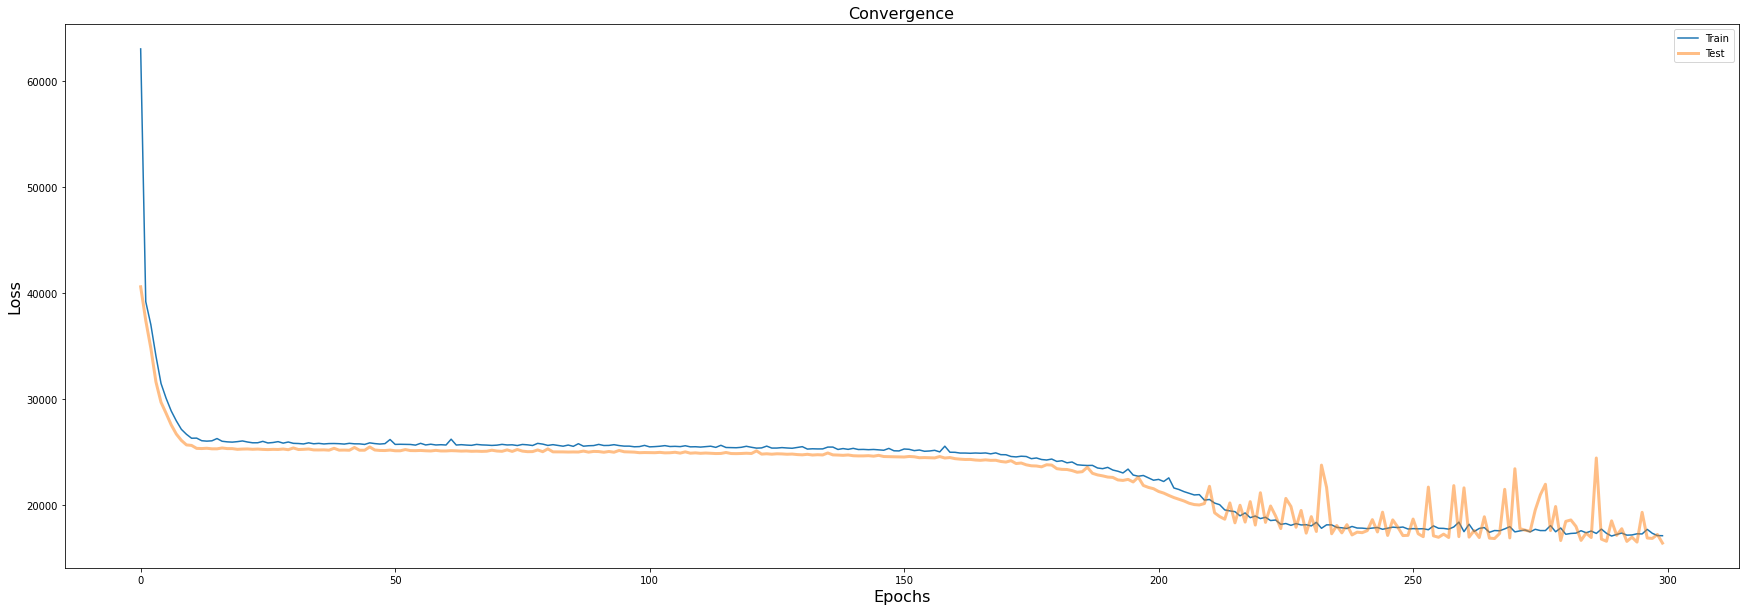

In [16]:
plt.figure(figsize=(30, 10))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()

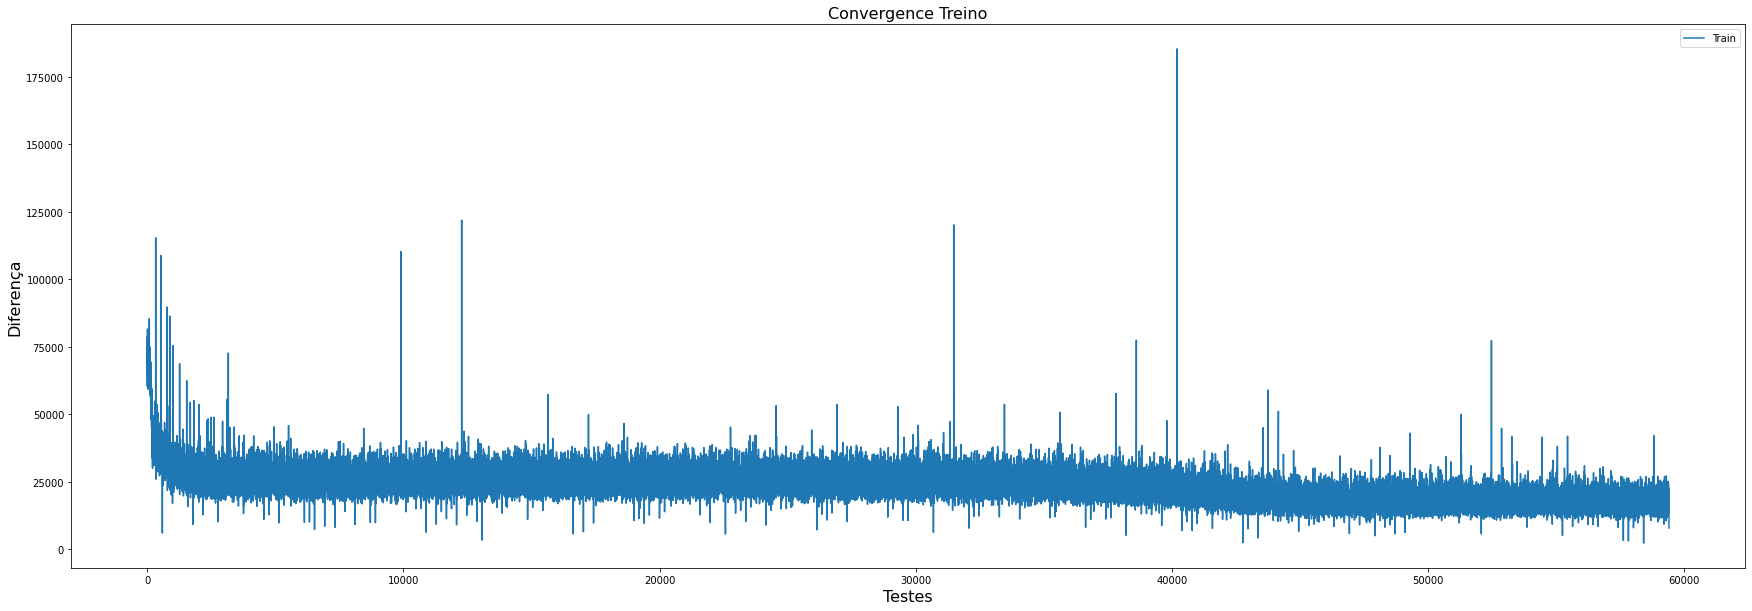

In [17]:
plt.figure(figsize=(30, 10))
plt.plot(dif_train, label='Train')
plt.xlabel('Testes', fontsize=16)
plt.ylabel('Diferença', fontsize=16)
plt.title('Convergence Treino', fontsize=16)
plt.legend()
plt.show()

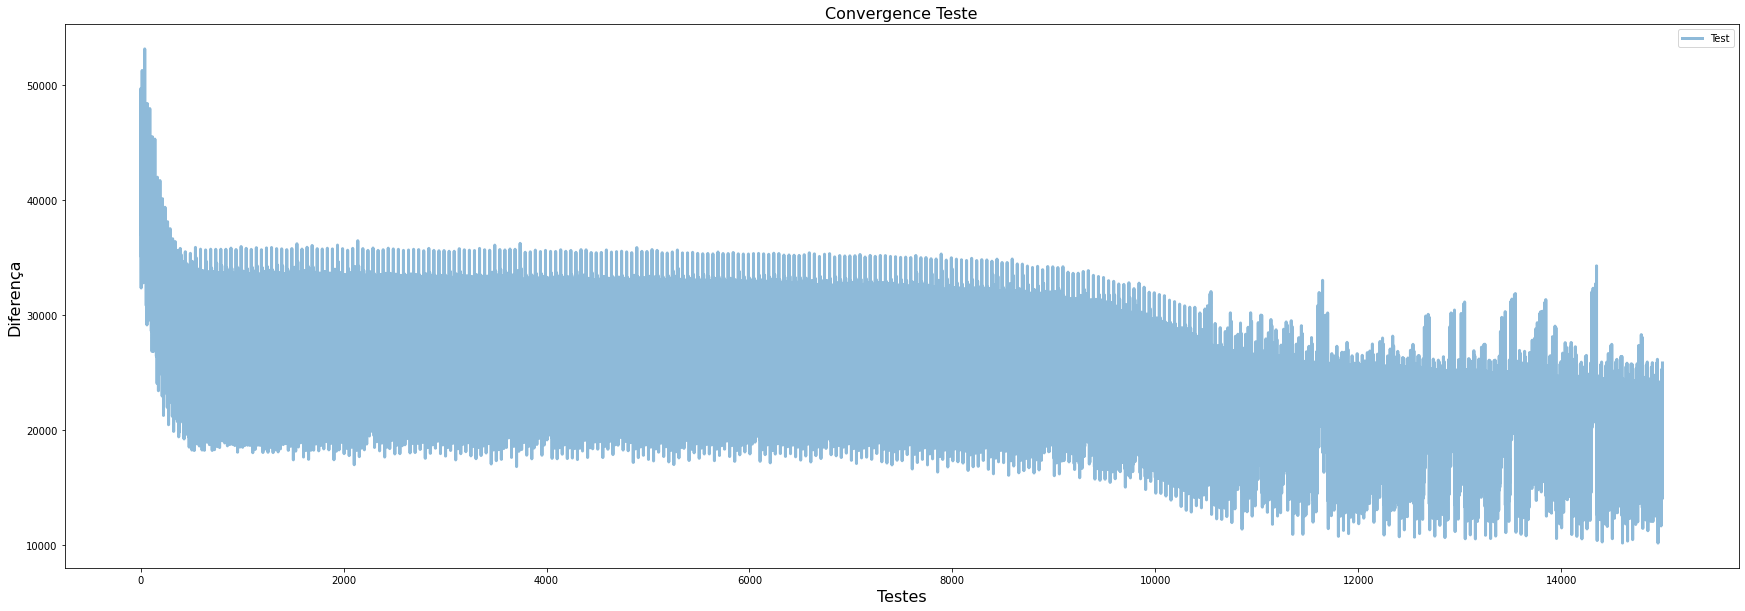

In [18]:
plt.figure(figsize=(30, 10))
plt.plot(dif_test, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Testes', fontsize=16)
plt.ylabel('Diferença', fontsize=16)
plt.title('Convergence Teste', fontsize=16)
plt.legend()
plt.show()

## Melhores Loss

In [19]:
train_losses = np.asarray(train_losses)
test_losses = np.asarray(test_losses)
dif_train = np.asarray(dif_train)
dif_test = np.asarray(dif_test)

print(f'Menor Valor de Loss por Época de Treino: {min(train_losses)}')
print(f'Maior Valor de Loss por Época de Treino: {max(train_losses)}')
print(f'Valor Médio de Loss por Época de Treino: {train_losses.mean()}')

print()

print(f'Menor Valor de Loss por Época de Teste: {min(test_losses)}')
print(f'Maior Valor de Loss por Época de Teste: {max(test_losses)}')
print(f'Valor Médio de Loss por Época de Teste: {test_losses.mean()}')

print()

print(f'Menor Valor de Loss por Registro de Treino: {min(dif_train)}')
print(f'Maior Valor de Loss por Registro de Treino: {max(dif_train)}')
print(f'Valor Médio de Loss por Registro de Treino: {dif_train.mean()}')

print()

print(f'Menor Valor de Loss por Registro de Teste: {min(dif_test)}')
print(f'Maior Valor de Loss por Registro de Teste: {max(dif_test)}')
print(f'Valor Médio de Loss por Registro de Teste: {dif_test.mean()}')

Menor Valor de Loss por Época de Treino: 17051.62109375
Maior Valor de Loss por Época de Treino: 63056.26171875
Valor Médio de Loss por Época de Treino: 23247.658203125

Menor Valor de Loss por Época de Teste: 16385.439453125
Maior Valor de Loss por Época de Teste: 40590.8125
Valor Médio de Loss por Época de Teste: 22850.22265625

Menor Valor de Loss por Registro de Treino: 2177.5966796875
Maior Valor de Loss por Registro de Treino: 185318.8125
Valor Médio de Loss por Registro de Treino: 23247.658203125

Menor Valor de Loss por Registro de Teste: 10126.130859375
Maior Valor de Loss por Registro de Teste: 53129.96484375
Valor Médio de Loss por Registro de Teste: 22850.22265625


In [20]:
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {0: {'step': 59400, 'exp_avg': tensor([[-3.2246e+03,  1.9554e+02,  8.2499e+00, -2.8833e+00, -6.7679e-01,
         -2.8848e+00,  1.7270e+03, -9.9776e+04,  4.1407e+00, -8.8122e-02],
        [ 1.3513e+03, -6.6337e+01, -2.6296e+00,  9.4540e-01,  3.4300e-01,
          1.5548e+00, -4.7269e+02,  3.5841e+04, -1.3549e+00,  4.0183e-02],
        [ 5.2034e+03, -2.9230e+02, -1.2220e+01,  4.7678e+00,  1.2515e+00,
          5.1700e+00, -2.3989e+03,  1.7336e+05, -6.2881e+00,  1.0623e-01],
        [ 4.2739e+03, -2.5298e+02, -1.0613e+01,  3.8593e+00,  9.5449e-01,
          4.0123e+00, -2.1710e+03,  1.3445e+05, -5.3632e+00,  1.0736e-01],
        [ 8.1780e+03, -2.9184e+02, -1.0393e+01,  7.1973e+00,  3.1411e+00,
          1.2273e+01, -8.1360e+02,  3.2380e+05, -6.5002e+00,  1.2716e-01]]), 'exp_avg_sq': tensor([[9.0196e+08, 3.6346e+05, 2.8467e+03, 7.0696e+01, 3.6411e+02, 3.7243e+03,
         6.3651e+08, 6.4809e+11, 4.3677e+02, 1.6595e+00],
        [1.1491e+08, 4.6219e+04, 3.61

In [21]:
# torch.save(net, 'modelo_classificao_t')

In [22]:
# testeModelo = torch.load('modelo_classificao-3')
# testeModelo.eval()

In [23]:
#lista = [1425,45,4,2,2,0,2019, 61000, 1.6,0]
#tensor = torch.FloatTensor(lista)
#valor = testeModelo.forward(tensor).item()
#valor

In [24]:
# vw = pd.read_csv('ka.csv')
#vw.drop(['combustivel', 'blindado', 'cor', 'potenciamotor'], axis=1, inplace=True)
# vw.head()

In [25]:
# dif = []
# real = []
# previsto = []
# for i in range(vw.shape[0]):
#     tensor = torch.FloatTensor(np.asarray(vw.iloc[i, :-1]))    
#     valor = testeModelo.forward(tensor).item()
#     dif.append(float(round(valor-np.asarray(vw.iloc[i,-1]), 2)))
#     print(f"{np.asarray(vw.iloc[i,-1])} -> {round(valor, 2)} => {round(valor-np.asarray(vw.iloc[i,-1]), 2)}")    
#     real.append(vw.iloc[i,-1])
#     previsto.append(valor)

In [26]:
# dif = np.asarray(dif)

In [27]:
# dif

In [28]:
# print(min(dif), max(dif), dif.mean())

In [29]:
# print(min(dif[dif > 0]), max(dif[dif > 0]), dif[dif > 0].mean())

In [30]:
# dif[dif > 0].std()

In [31]:
# plt.figure(figsize=(20, 9))
# plt.plot(real, label='Real', linewidth=3, alpha=0.5)
# plt.plot(previsto, label='Previsto')
# plt.xlabel('Testes', fontsize=16)
# plt.ylabel('Diferença', fontsize=16)
# plt.title('Convergence Teste', fontsize=16)
# plt.legend()
# plt.show()

In [32]:
# plt.figure(figsize=(20, 9))
# plt.plot(real[100:200], label='Real', linewidth=3, alpha=0.5)
# plt.plot(previsto[100:200], label='Previsto')
# plt.xlabel('Testes', fontsize=16)
# plt.ylabel('Diferença', fontsize=16)
# plt.title('Convergence Teste', fontsize=16)
# plt.legend()
# plt.show()